Implement the demand response

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

Function collection

In [2]:
def extract_cyc(profile) -> tuple:
    """
    Extract the operation cycles from the profile.
    Returns the start times and profile of the cycles.
    """
    cycles = [] # list of operation cycles
    cycle = [] # current operation cycle
    for i in range(len(profile)):
        if profile[i] > 0:
            cycle.append(i)
        else: # if the profile is 0, it means the cycle is over
            if cycle:
                cycles.append(cycle)
                cycle = []
    if cycle:
        cycles.append(cycle)
        
    return [c[0] for c in cycles], [profile[c] for c in cycles]

def constrain_nonflex(model, cycle_start, cycle_profile, duration, tolerance, name: str):
    """
    Build the optimization constraints for the non-flexible appliances.
    """
    # Create variables
    num_cycle = len(cycle_start)

    app_energy = model.addVars(num_cycle, duration, vtype=gp.GRB.CONTINUOUS, lb=0, name=name+"_power")
    app_start = model.addVars(num_cycle, duration, vtype=gp.GRB.BINARY, name=name+"_start")

    for i, start in enumerate(cycle_start):
        len_cycle = len(cycle_profile[i])
        # constraint (1)&(2): The starting time of each operation should not deviate from the consumer preference
        # time by more than a certain time tolerance. I think it doesn't make any sense to bring the operation ahead
        # of the preference time, so we only consider the delay.
        model.addConstr(gp.quicksum(app_start[i, j] for j in range(start, start + tolerance + 1)) == 1, name=name+f"_start_constr_{i}")

        # constraint: all the operations should complete before the end of the day
        model.addConstr(gp.quicksum(app_start[i, j] for j in range(start, duration-len_cycle+1)) == 1, name=name+f"end_constr_{i}")

        # constraint: every operation should only start once
        model.addConstr(gp.quicksum(app_start[i, j] for j in range(duration)) == 1, name=name+f"_unique_constr_{i}")

        # constraint (3): the operation should not start before the end of the previous operation
        if i > 0:
            model.addConstr(gp.quicksum((app_start[i, j]-app_start[i-1, j])*j for j in range(start, start + tolerance + 1)) >= len_cycle, name=name+f"_overlap_constr_{i}")
        # constraint (4): the shifted operation is calculated as the convolution of the profile and the decision variable
        for j in range(duration):
            conv = gp.quicksum(app_start[i, j-k] * cycle_profile[i][k] for k in range(len_cycle) if j-k >= 0)
            model.addConstr(app_energy[i, j] == conv, name=f"wm_power_constr_{i}_{j}")

    return app_energy, app_start

def constrain_flex(model, soc_init, soc_demand, soc_max, pos_rate, neg_rate, t_in, t_out, duration, name: str):
    """
    Build the optimization constraints for the flexible appliances.
    """
    # constraint (6): the power rate is limited by the maximum
    # TODO: the lower bound can be set to a negative value if bidirectional charging is allowed
    app_energy = model.addVars(duration, vtype=gp.GRB.CONTINUOUS, lb=neg_rate, ub=pos_rate, name=name+"_power")
    # assume the lower bound of soc is internally higher than 0 
    app_soc = model.addVars(t_out-t_in+1, vtype=gp.GRB.CONTINUOUS, lb=0, ub=soc_max, name=name+"_soc")

    # constraint (5): the energy demand has to be satisfied within the time window [plug_in, plug_out]
    model.addConstr(gp.quicksum(app_energy[t] for t in range(t_in, t_out)) == soc_demand, name=name+"_demand_constr")
    for t in range(duration):
        if t < t_in or t >= t_out:
            # constraint (7): the power rate is limited to 0 outside the time window [plug_in, plug_out]
            model.addConstr(app_energy[t] == 0, name=name+f"_power_constr_{t}")
        
        # transition function of the state of charge
        else:
            if t == t_in:
                model.addConstr(app_soc[0] == soc_init, name=name+f"_soc_constr_{t}")
            else:
                model.addConstr(app_soc[t-t_in+1] == app_soc[t-t_in] + app_energy[t], name=name+f"_soc_constr_{t}") 
    
    return app_energy, app_soc 

def constrain_pv(model, demand, pv_pred, battery_init, battery_max, energy_rate, duration, name: str):
    """
    Build the optimization constraints for the PV system.
    """
    battery_energy = model.addVars(duration, vtype=gp.GRB.CONTINUOUS, lb=-energy_rate, ub=energy_rate, name=name+"_battery_charge") 
    battery_soc = model.addVars(duration+1, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_max, name=name+"battery_soc")

    # initialize the battery soc
    model.addConstr(battery_soc[0] == battery_init, name=name+"_battery_soc_init")
    for t in range(duration):
        # transition function of soc
        model.addConstr(battery_soc[t+1] == battery_energy[t] + battery_soc[t], name=name+f"_battery_soc_constr_{t}")

        # constraint: the aggregation of total demand and energy charged into the battery should be greater than pv
        model.addConstr(pv_pred[t] - demand[t] <= battery_energy[t], name=name+f"_battery_pv_{t}")

    return battery_energy, battery_soc

def get_profile(var, row, col, type='nonflex'):
    """
    Get the profile of a gurobi variable.
    row: number of cycles
    col: number of time steps
    """
    if type == 'nonflex':
        return [sum(var[i, t].X for i in range(row)) for t in range(col)]
    
    if type == 'flex':
        return [var[t].X for t in range(col)]

load the houldhold data and the dynamic price

In [3]:
household = pd.read_csv('household_dummy_data.csv')

# time-related data
timeseries = household.iloc[:, 0].tolist()
duration = len(timeseries)

critical_ini = np.array(household['Critical appliances'])
pv_ini = np.array(household['PV']) # The assumption is that our prediction of pv generation is 100% accurate

# waching machine related settings
wm_ini = np.array(household['Washing Machine'])
wm_cyc_start, wm_cyc_profile = extract_cyc(wm_ini) # start times and profiles of the cycles
wm_tolerance = 24 # The starting time of the cycle can not deviate from the preference time by 6 hours

# dishwasher related settings
dishwasher_ini = np.array(household['Dishwasher'])
dw_cyc_start, dw_cyc_profile = extract_cyc(dishwasher_ini) # start times and profiles of the cycles
dw_tolerance = 24 # should have dishes washed before dinner time

# pv related settings
pv_ini = np.array(household['PV']) # The assumption is that our prediction of pv generation is 100% accurate
pv_battery_max = 10 # battery capacity in kWh
pv_battery_init = 5 # random
pv_battery_energy_rate = 1

# EV related settings
home_charger = 4 # maximum power of home charger in kW
energy_rate = home_charger / 4 # maximum amout of energy that can be charged in 15 minutes
ev_ini = np.zeros(duration)

soc_max = 67 # ev battery capacity in kWh taken from the Tesla Model Y
soc_demand = 6 # energy demand of the EV in kWh, the assumption is that the EV is fully charged at the end of the day
soc_init = soc_max - soc_demand

ev_in = 24 # plug in at 2016-05-01 18:00
ev_out = 88 # plug out at 2016-05-02 10:00
ev_ini[ev_in:ev_in+int(np.ceil(soc_demand/energy_rate))] = energy_rate # dumb charging of EV, charging at 4 kW starting at 18:00 to fill the depletion of 6 kWh

# price-related data 
price = np.array(household['Dynamic Price']) / 1000 # convert to euro/kWh
price_penalty = 0.1 # tuning parameter for the price penalty
power_th = 3 # threshold for peak load in kW

Benchmark: w/o PV, w/o demand response
meaning EV is charged using the dumb charging strategy. The penalty works in the following way: if the total load exceeds the threshold, the price will become the product of the maximum price and a tuning parameter.

In [4]:
tot_demand = dishwasher_ini + critical_ini + wm_ini + ev_ini
cost_benchmark = np.dot(tot_demand, price) + price_penalty * np.sum(tot_demand[tot_demand > power_th/4]) # cost of the benchmark scenarioeuro')
print('Cost benchmark: ', cost_benchmark, 'euro')

Cost benchmark:  1.53078744 euro


First Scenario: Demand Response with unidirectional EV 

In [5]:
#########################  Scenario 1 #########################
# Create a Gurobi model
model1 = gp.Model("Scenario 1: uni EV")
# Washing machine related variables
wm_energy, _ = constrain_nonflex(model1, wm_cyc_start, wm_cyc_profile, duration, wm_tolerance, "wm")
model1.update()

# Dishwasher related variables
dw_energy, _ = constrain_nonflex(model1, dw_cyc_start, dw_cyc_profile, duration, dw_tolerance, "dw")
model1.update()

# EV related variables
ev_energy, _ = constrain_flex(model1, soc_init, soc_demand, soc_max, energy_rate, 0, ev_in, ev_out, duration, "ev")
model1.update()


tot_demand = [] # add profiles of all cycles together to get the final wm power profile
for t in range(duration):
    demand = gp.quicksum(wm_energy[i, t] for i in range(len(wm_cyc_start)))
    demand += gp.quicksum(dw_energy[i, t] for i in range(len(dw_cyc_start)))
    demand += ev_energy[t] + critical_ini[t]

    tot_demand.append(demand) 

# Now deal with the objective function considering the violation of power threshold
excess = model1.addVars(duration,
                       lb=0,
                       vtype=gp.GRB.CONTINUOUS,
                       name="excess_kw")
for t in range(duration):
    model1.addConstr(
        excess[t] >= tot_demand[t] - power_th/4,
        name=f"ex_def_{t}"
    )
    
# binary flag: 1 if we exceed (excess>0), 0 otherwise
penalty_flag = model1.addVars(duration,
                        vtype=gp.GRB.BINARY,
                        name="exceed_flag")

# big‐M constraint: if excess[t]>0 ⇒ flag[t]=1, else flag[t] can be 0
M = 1000.0   # “big‐M”: must exceed any possible (tot_demand*4 - P_th)
for t in range(duration):
    # if excess[t]>0 ⇒ flag[t]=1, else flag[t] can be 0
    model1.addConstr(excess[t] <= M * penalty_flag[t],
                    name=f"flag_def_{t}")
    
# cost part 1: cost of the energy consumed 
cost = gp.quicksum(
    price[t] * tot_demand[t]
    for t in range(duration)
)
# cost part 2: penalty for exceeding the power threshold
cost += price_penalty * gp.quicksum(tot_demand[t] * penalty_flag[t] for t in range(duration))

model1.setObjective(cost, gp.GRB.MINIMIZE)
# Solve the model
model1.optimize()

# Check the optimization status
if model1.status == gp.GRB.OPTIMAL:
    print("Optimal solution found.")
    print("Objective value (cost):", model1.objVal)
else:
    print("No optimal solution found. Status code:", model1.status)

Set parameter Username
Set parameter LicenseID to value 2648225
Academic license - for non-commercial use only - expires 2026-04-07
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows Server 2022.0 (21996.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 587 rows, 929 columns and 3580 nonzeros
Model fingerprint: 0xe5918a10
Model has 384 quadratic objective terms
Variable types: 545 continuous, 384 integer (384 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [2e-03, 8e-02]
  QObjective range [2e-01, 2e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [2e-02, 6e+01]
Found heuristic solution: objective 3.0191381
Presolve removed 423 rows and 630 columns
Presolve time: 0.04s
Presolved: 310 rows, 445 columns, 1714 nonzeros
Found heuristic solution: objective 2.9369381
Variable types:

Second Scenario: Demand Response with bidirectional EV

Can be realized by simply adding a lower bound of energy flowing into the EV in the first scenario 

Third Scenario: Demand Response with PV and BESS

In [6]:
#########################  Scenario 1 #########################
# Create a Gurobi model
model3 = gp.Model("Scenario 3: PV + BESS")
# Washing machine related variables
wm_energy, _ = constrain_nonflex(model3, wm_cyc_start, wm_cyc_profile, duration, wm_tolerance, "wm")
model3.update()

# Dishwasher related variables
dw_energy, _ = constrain_nonflex(model3, dw_cyc_start, dw_cyc_profile, duration, dw_tolerance, "dw")
model3.update()


tot_demand = [] # add profiles of all cycles together to get the final wm power profile
for t in range(duration):
    demand = gp.quicksum(wm_energy[i, t] for i in range(len(wm_cyc_start)))
    demand += gp.quicksum(dw_energy[i, t] for i in range(len(dw_cyc_start)))
    demand += critical_ini[t] + ev_ini[t]

    tot_demand.append(demand) 

# PV and BESS related variables
battery_energy, _ = constrain_pv(model3, tot_demand, pv_ini, pv_battery_init, pv_battery_max, pv_battery_energy_rate, duration, 'pv')
model3.update()

grid_import = [tot_demand[t] - pv_ini[t] + battery_energy[t] for t in range(duration)]

# Now deal with the objective function considering the violation of power threshold
excess = model3.addVars(duration,
                       lb=0,
                       vtype=gp.GRB.CONTINUOUS,
                       name="excess_kw")
for t in range(duration):
    model3.addConstr(
        excess[t] >= grid_import[t] - power_th/4,
        name=f"ex_def_{t}"
    )
    
# binary flag: 1 if we exceed (excess>0), 0 otherwise
penalty_flag = model3.addVars(duration,
                        vtype=gp.GRB.BINARY,
                        name="exceed_flag")

# big‐M constraint: if excess[t]>0 ⇒ flag[t]=1, else flag[t] can be 0
M = 1000.0   # “big‐M”: must exceed any possible (tot_demand*4 - P_th)
for t in range(duration):
    # if excess[t]>0 ⇒ flag[t]=1, else flag[t] can be 0
    model3.addConstr(excess[t] <= M * penalty_flag[t],
                    name=f"flag_def_{t}")
    
# cost part 1: cost of the energy consumed 
cost = gp.quicksum(
    price[t] * grid_import[t]
    for t in range(duration)
)
# cost part 2: penalty for exceeding the power threshold
cost += price_penalty * gp.quicksum(grid_import[t] * penalty_flag[t] for t in range(duration))

model3.setObjective(cost, gp.GRB.MINIMIZE)
# Solve the model
model3.optimize()

# Check the optimization status
if model3.status == gp.GRB.OPTIMAL:
    print("Optimal solution found.")
    print("Objective value (cost):", model3.objVal)
else:
    print("No optimal solution found. Status code:", model3.status)

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows Server 2022.0 (21996.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 683 rows, 961 columns and 3967 nonzeros
Model fingerprint: 0x9426c45c
Model has 384 quadratic objective terms
Variable types: 577 continuous, 384 integer (384 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-04, 2e-01]
  QObjective range [2e-01, 2e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e-03, 7e+00]
Presolve removed 394 rows and 579 columns
Presolve time: 0.02s
Presolved: 455 rows, 548 columns, 1696 nonzeros
Variable types: 391 continuous, 157 integer (157 binary)
Found heuristic solution: objective 0.2236692
Found heuristic solution: objective 0.1987176

Root relaxation: objective -1.101183e+00, 456 iterations, 0.00 seconds (0.01 work units)


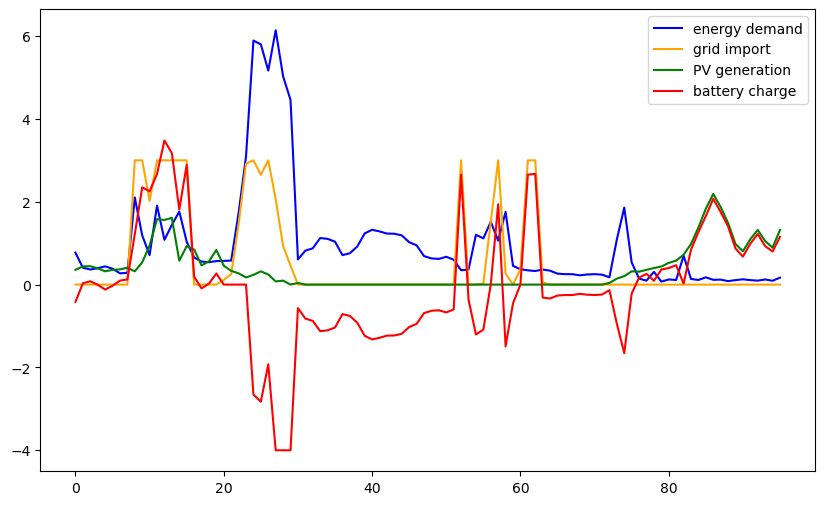

In [7]:
plt.figure(figsize=(10, 6))
total_ini = ev_ini + wm_ini + dishwasher_ini + critical_ini
wm_optimized = get_profile(wm_energy, len(wm_cyc_start), duration, type='nonflex')
dw_optimized = get_profile(dw_energy, len(dw_cyc_start), duration, type='nonflex')
battery_ch = get_profile(battery_energy, duration, duration, type='flex')
# ev_optimized = get_profile(ev_energy, duration, duration, type='flex')

grid_import_optimzed = [wm_optimized[t] + dw_optimized[t] + ev_ini[t] + critical_ini[t] - pv_ini[t] + battery_ch[t] for t in range(duration)]
total_demand = [wm_optimized[t] + dw_optimized[t] + ev_ini[t] + critical_ini[t] for t in range(duration)]

plt.plot([x * 4 for x in total_demand], label='energy demand', color='blue')
plt.plot([x * 4 for x in grid_import_optimzed], label='grid import', color='orange')
plt.plot(pv_ini*4, label='PV generation', color='green')
plt.plot([x * 4 for x in battery_ch], label='battery charge', color='red')
plt.legend()
# plt.plot(pv_ini*4, label='PV generation', color='green')